In [132]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgb
import xgboost as xgb
import seaborn as sns
from plotnine import *
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import scipy.stats as stat
%matplotlib inline

## 1. 读取数据

In [119]:
train=pd.read_csv('zhengqi_train.txt',delimiter='\t')
test=pd.read_csv('zhengqi_test.txt',delimiter='\t')
print(train.shape)
print(test.shape)

(2888, 39)
(1925, 38)


训练集有2888个训练样本39各变量，测试集包含1925个样本和38个变量。  
为方便研究和可视化，下面将训练集和测试集合并，并观察数据集结构：

In [120]:
#新增一列用以区分训练集和测试集
train['type']='train'
test['type']='test'
#合并数据集
full=pd.concat([train,test],axis=0,sort=False)
full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4813 entries, 0 to 1924
Data columns (total 40 columns):
V0        4813 non-null float64
V1        4813 non-null float64
V2        4813 non-null float64
V3        4813 non-null float64
V4        4813 non-null float64
V5        4813 non-null float64
V6        4813 non-null float64
V7        4813 non-null float64
V8        4813 non-null float64
V9        4813 non-null float64
V10       4813 non-null float64
V11       4813 non-null float64
V12       4813 non-null float64
V13       4813 non-null float64
V14       4813 non-null float64
V15       4813 non-null float64
V16       4813 non-null float64
V17       4813 non-null float64
V18       4813 non-null float64
V19       4813 non-null float64
V20       4813 non-null float64
V21       4813 non-null float64
V22       4813 non-null float64
V23       4813 non-null float64
V24       4813 non-null float64
V25       4813 non-null float64
V26       4813 non-null float64
V27       4813 non-null float

In [91]:
null_df=pd.DataFrame()
null_df['feature']=test.columns
tmp=[]
for col in test.columns:
    tmp.append(train[col].isna().sum()/len(train[col]))
null_df['train']=tmp
tmp=[]
for col in test.columns:
    tmp.append(test[col].isna().sum()/len(test[col])) 
null_df['test']=tmp
print(null_pct)

   feature  train  test
0       V0    0.0   0.0
1       V1    0.0   0.0
2       V2    0.0   0.0
3       V3    0.0   0.0
4       V4    0.0   0.0
5       V5    0.0   0.0
6       V6    0.0   0.0
7       V7    0.0   0.0
8       V8    0.0   0.0
9       V9    0.0   0.0
10     V10    0.0   0.0
11     V11    0.0   0.0
12     V12    0.0   0.0
13     V13    0.0   0.0
14     V14    0.0   0.0
15     V15    0.0   0.0
16     V16    0.0   0.0
17     V17    0.0   0.0
18     V18    0.0   0.0
19     V19    0.0   0.0
20     V20    0.0   0.0
21     V21    0.0   0.0
22     V22    0.0   0.0
23     V23    0.0   0.0
24     V24    0.0   0.0
25     V25    0.0   0.0
26     V26    0.0   0.0
27     V27    0.0   0.0
28     V28    0.0   0.0
29     V29    0.0   0.0
30     V30    0.0   0.0
31     V31    0.0   0.0
32     V32    0.0   0.0
33     V33    0.0   0.0
34     V34    0.0   0.0
35     V35    0.0   0.0
36     V36    0.0   0.0
37     V37    0.0   0.0
38    type    0.0   0.0


可以看出训练集和测试集均包含V0-V37共38个特征且均为连续数值型特征，target列为要预测的目标变量。所有变量都不包含缺失值。

## 2. 数据分析
结合赛题的实际背景对数据集包含的内容和结构进行初步探究。数据是经脱敏后的锅炉传感器采集的数据（采集频率是分钟级别），但具体意义未知。  
先观察各个变量在测试集和训练集各自的数据分布是否相同，若同一特征在训练集和测试集的数据分布有显著差异，会降低预测模型的泛化能力，需要将这些特征识别出来并且从特征中移除：

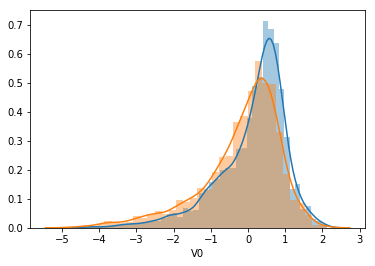

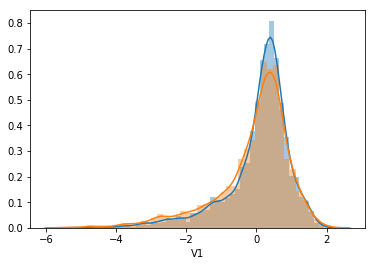

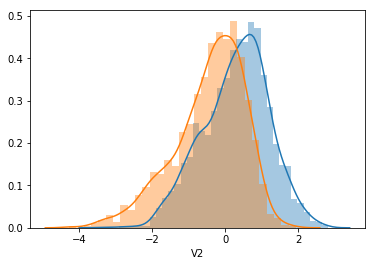

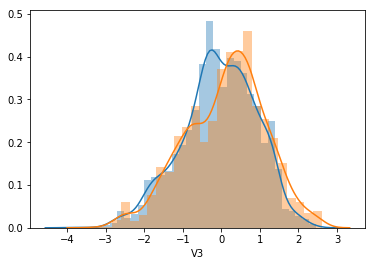

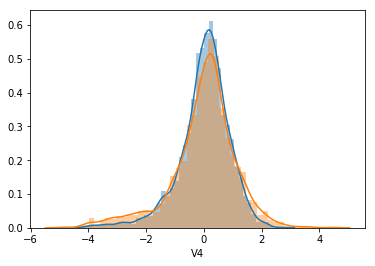

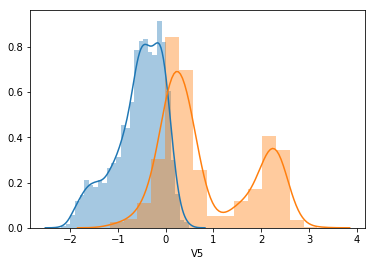

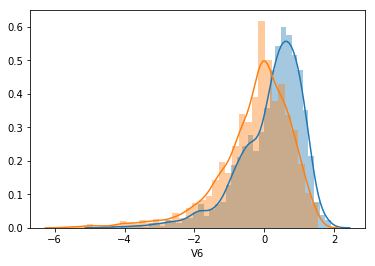

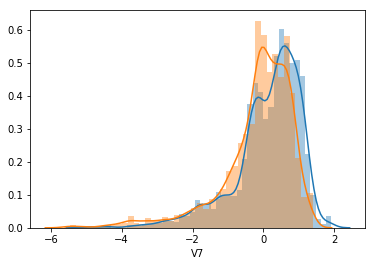

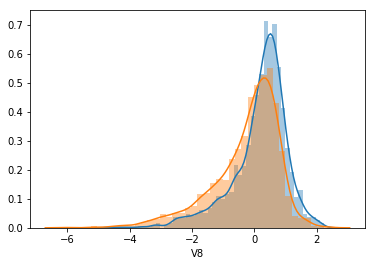

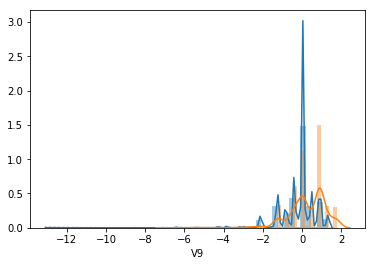

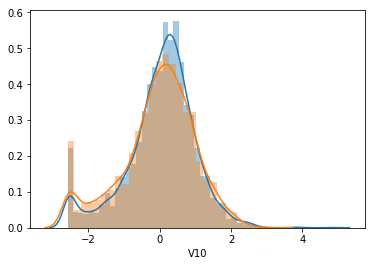

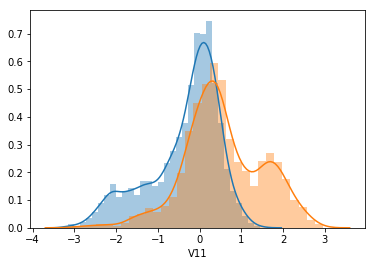

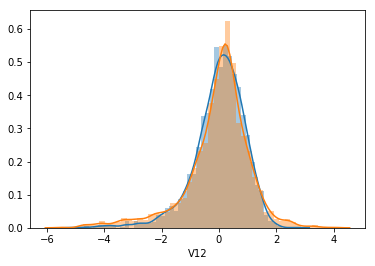

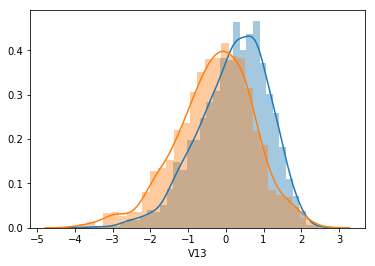

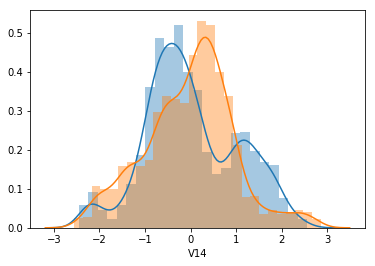

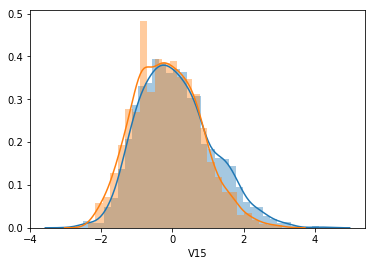

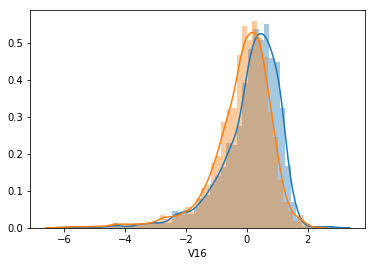

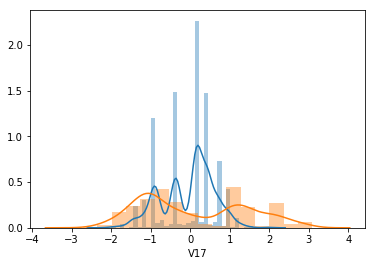

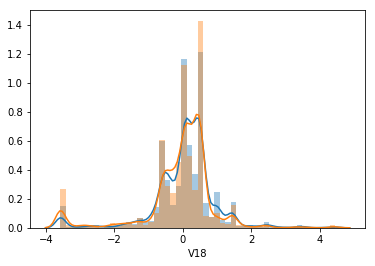

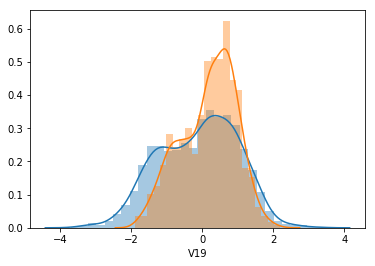

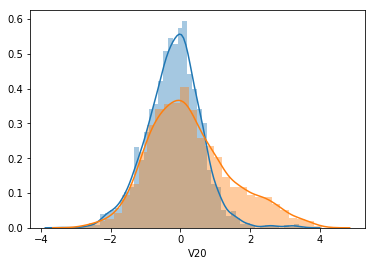

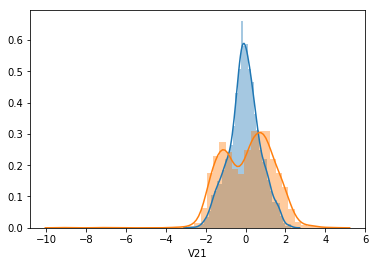

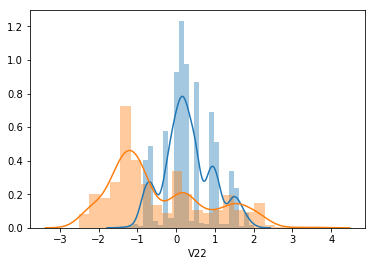

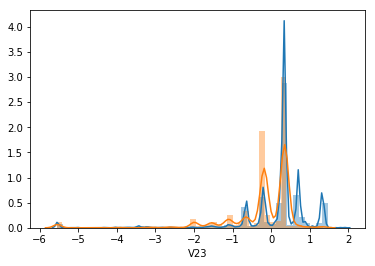

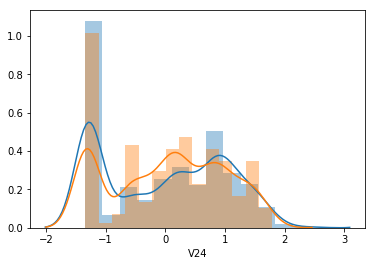

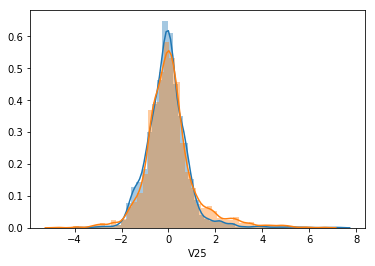

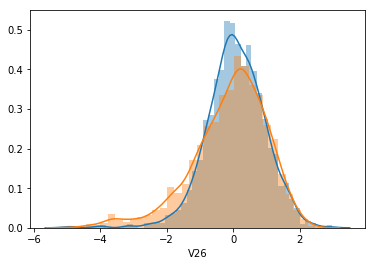

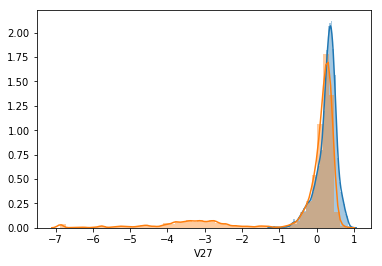

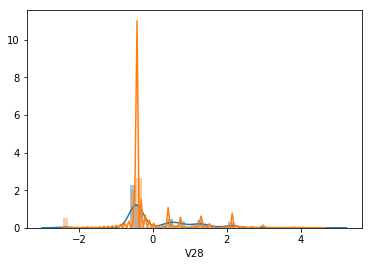

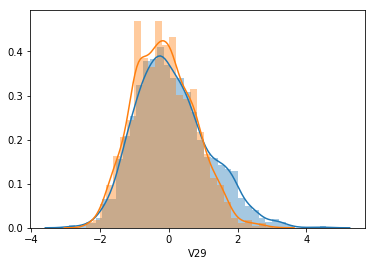

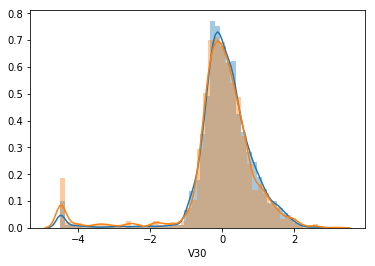

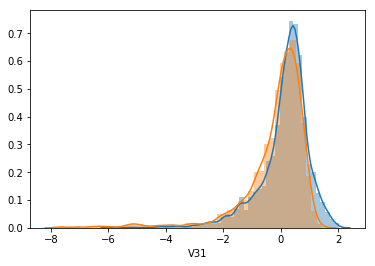

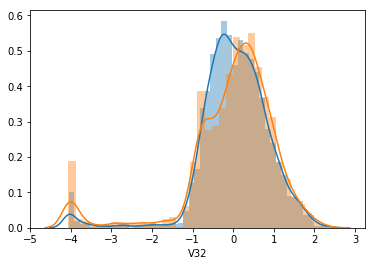

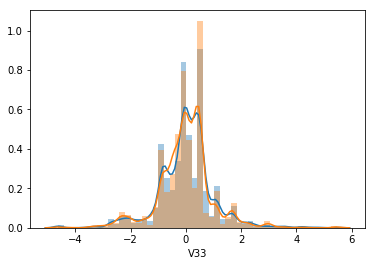

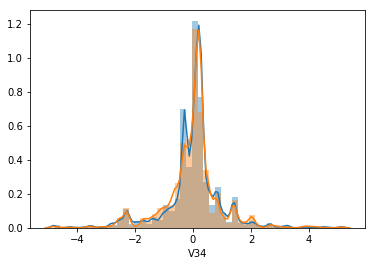

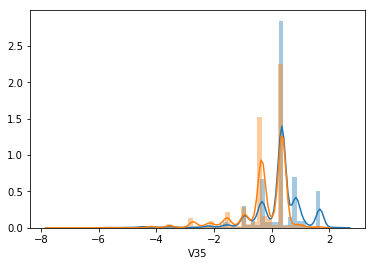

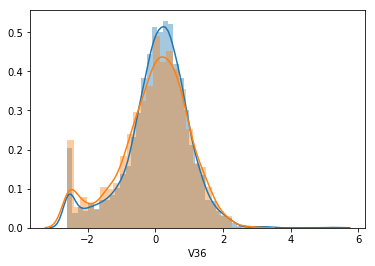

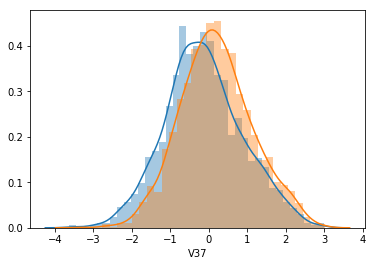

In [73]:
#对每一个特征，分别在训练集和测试集绘制密度图
for col in full.iloc[:,:38].columns:
    sns.distplot(full.loc[full['type']=='train',col])
    sns.distplot(full.loc[full['type']=='test',col])
    plt.show()

从上面的各特征数据分布图可以看出，[V5,V9,V11,V14,V17,V21,V27,V28]这几个特征在训练集中的数据分布与它们在测试集的数据分布有很显著的差异，使用这些特征建模会影响模型在测试集上的表现，所以将这些特征删除。

下面对训练集绘制各特征和目标变量之间的热力图，计算相关系数，进一步筛选特征

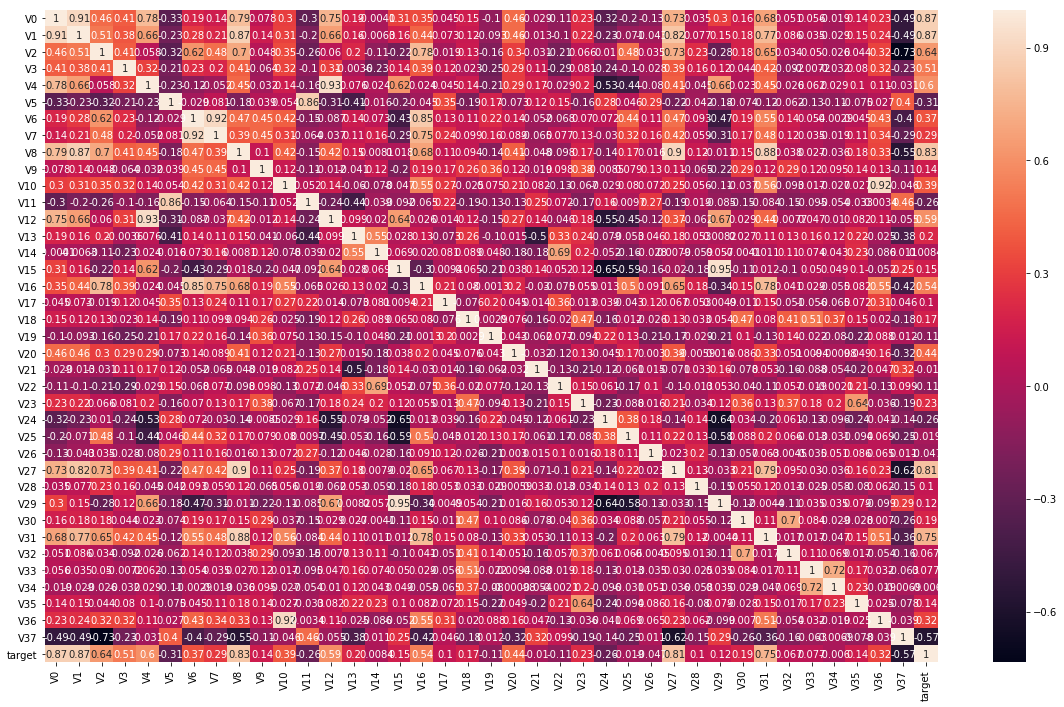

In [92]:
_,ax=plt.subplots(1,1,figsize=(20,12))
sns.heatmap(full[full['type']=='train'].corr(),ax=ax,annot=True)

可以看到特征V25，V34于目标变量的相关系数绝对值接近于0，与目标变量几乎不相关。 
剔除变量：

In [121]:
full.drop(['V5','V9','V11','V14','V17','V21','V27','V28','V25','V34'],axis=1,inplace=True)
full.shape

(4813, 30)

标准化数据：

In [122]:
scaler=MinMaxScaler()
y=train['target']
full.drop(['target','type'],axis=1,inplace=True)
full_minmax=pd.DataFrame(scaler.fit_transform(full),columns=full.columns)
x=full_minmax.iloc[:len(train)]
test=full_minmax.iloc[len(train):]

## 3. 建模尝试
分割数据集，构建训练数据和验证数据

XGBoost建模尝试：

In [136]:
train_x,val_x,train_y,val_y=train_test_split(x,y,test_size=0.2,random_state=15)
xgb_full=xgb.DMatrix(data=x,label=y)
xgb_train=xgb.DMatrix(data=train_x,label=train_y)
xgb_val=xgb.DMatrix(data=val_x,label=val_y)
xgb_test=xgb.DMatrix(data=test)

In [140]:
result={}
#cv_result={}
param={'eta':0.03,'eval_metric':'rmse','tree_method':'gpu_hist','subsample':0.8,'colsample_bytree':0.8,
      'bagging_freq':5,'max_depth':6,'reg_lambda':1.2,'reg_alpha':0,'min_child_weight':0.7}
#cv_result=xgb.cv(param,xgb_train,nfold=5,num_boost_round=500,early_stopping_rounds=50,verbose_eval=False)
xgbmodel=xgb.train(param,xgb_train,num_boost_round=500,early_stopping_rounds=50,verbose_eval=False,
                   evals=[(xgb_train,'train'),(xgb_val,'val')], evals_result=result)

In [149]:
#用拟合的模型预测结果
pred=pd.DataFrame({'prediction':xgbmodel.predict(xgb_test).round(3)})
pred.to_csv('submission.txt',header=False,index=False)

## 后续优化
剔除离群点  
目标值变换  
模型融合  
stacking  